In [1]:
# Import libraries and functions

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import csv
import os,random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout, Activation, Flatten
from keras.layers import LSTM, SimpleRNN, Bidirectional
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.io import loadmat

import datetime
now = datetime.datetime.now

Using TensorFlow backend.


In [2]:
timesteps = 240, # timestep
nr = 90   # repetition number
n_dim = 117  # Dimension of data sequences
dropout_rate = 0.2   # Droput rate

In [3]:
x = loadmat('M1-DeepSquat.mat')
correct = x['Train_Data']
T1 = correct.shape[1]
incorrect = x['Test_Data']
T2 = incorrect.shape[1]
Correct_label = np.loadtxt('Score_Train.csv', delimiter = ',')
Incorrect_label = np.loadtxt('Score_Test.csv', delimiter = ',')
Correct_label = np.reshape(Correct_label,(90,1))
Incorrect_label = np.reshape(Incorrect_label,(90,1))

In [4]:
Train_Data = []
Test_Data = []
for i in range(T1):
    Train_Data.append(correct[0,i])
for i in range(T2):
    Test_Data.append(incorrect[0,i])
Train_Data = np.dstack(Train_Data)
Correct_data = np.rollaxis(Train_Data,-1)
Test_Data = np.dstack(Test_Data)
Incorrect_data = np.rollaxis(Test_Data,-1)

In [5]:
print(Correct_data.shape, 'correct sequences')
print(Correct_label.shape, 'correct labels')
print(Incorrect_data.shape, 'incorrect sequences')
print(Incorrect_label.shape, 'incorrect labels')
print(Incorrect_label)

(90, 240, 117) correct sequences
(90, 1) correct labels
(90, 240, 117) incorrect sequences
(90, 1) incorrect labels
[[0.77070569]
 [0.76884138]
 [0.78070347]
 [0.77246476]
 [0.7844086 ]
 [0.77587035]
 [0.7777145 ]
 [0.78434538]
 [0.77252703]
 [0.78289385]
 [0.78193663]
 [0.78846781]
 [0.7803503 ]
 [0.78682076]
 [0.77666467]
 [0.78544192]
 [0.78890988]
 [0.78508961]
 [0.78187401]
 [0.78532129]
 [0.78228774]
 [0.79025917]
 [0.78706095]
 [0.78664029]
 [0.77175209]
 [0.81672516]
 [0.78656288]
 [0.77919494]
 [0.77625054]
 [0.78278811]
 [0.78206549]
 [0.78540818]
 [0.79901148]
 [0.79868875]
 [0.80289406]
 [0.78051864]
 [0.7998777 ]
 [0.79079386]
 [0.79017874]
 [0.7879019 ]
 [0.79022488]
 [0.79784416]
 [0.78826171]
 [0.79469148]
 [0.80274734]
 [0.78553233]
 [0.76860255]
 [0.77769118]
 [0.77494794]
 [0.78356183]
 [0.79654626]
 [0.77975411]
 [0.77475723]
 [0.78038023]
 [0.78483552]
 [0.79260353]
 [0.79275839]
 [0.80433152]
 [0.80461817]
 [0.79633012]
 [0.79736682]
 [0.7946005 ]
 [0.78768827]
 [

In [6]:
# Split the data into training and validation sets
# Training set: 70%
# Validation set: 30%

# First load the shuffled indices
f = open('Shuffled_Indices.csv')
csv_f = csv.reader(f)
indcs = list(csv_f)

# Extract the training and validation indices
trainidx1 = np.squeeze(np.asarray(indcs[:int(nr*0.7)], dtype = np.float64))
trainidx1 = np.asarray(trainidx1, dtype = np.int32)   # convert input to an array
valididx1 = np.squeeze(np.asarray(indcs[int(nr*0.7):nr], dtype = np.float64))
valididx1 = np.asarray(valididx1, dtype = np.int32)
trainidx2 = np.squeeze(np.asarray(indcs[nr:nr+int(nr*0.7)], dtype = np.float64))
trainidx2 = np.asarray(trainidx2, dtype = np.int32)
valididx2 = np.squeeze(np.asarray(indcs[nr+int(nr*0.7):], dtype = np.float64))
valididx2 = np.asarray(valididx2, dtype = np.int32)

# Training set: data and labels
train_x_1 = np.concatenate((Correct_data[trainidx1,:,:],Incorrect_data[trainidx2,:,:]))
s = np.arange(train_x_1.shape[0])
np.random.shuffle(s)
train_x = train_x_1[s]
print(train_x.shape, 'training data')

train_y_1 = np.concatenate((np.squeeze(Correct_label[trainidx1]),np.squeeze(Incorrect_label[trainidx2])))
train_y = train_y_1[s]
print(train_y.shape, 'training labels')

# Validation set: data and labels
valid_x = np.concatenate((Correct_data[valididx1,:,:],Incorrect_data[valididx2,:,:]))
print(valid_x.shape, 'validation data')
valid_y = np.concatenate((np.squeeze(Correct_label[valididx1]),np.squeeze(Incorrect_label[valididx2])))
print(valid_y.shape, 'validation labels')
# print(train_x[0].shape)

(124, 240, 117) training data
(124,) training labels
(56, 240, 117) validation data
(56,) validation labels


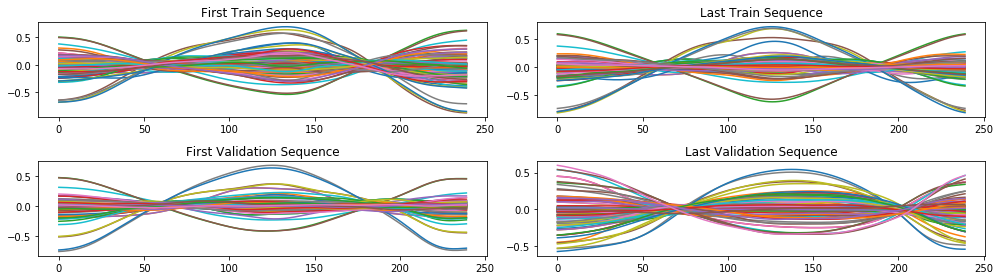

In [7]:
# Plot the first and last sequence in the training and validation data
%matplotlib inline
plt.figure(figsize = (14,4))
plt.subplot(2,2,1)
plt.plot(train_x[0])
plt.title('First Train Sequence')
plt.subplot(2,2,2)
plt.plot(train_x[-1])
plt.title('Last Train Sequence')
plt.subplot(2,2,3)
plt.plot(valid_x[0])
plt.title('First Validation Sequence')
plt.subplot(2,2,4)
plt.plot(valid_x[-1])
plt.title('Last Validation Sequence')
plt.tight_layout()
plt.show()

In [8]:
# Build RNN model ...
def Network():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(20, recurrent_dropout = 0.5, return_sequences = True), input_shape = (240,117)))
    model.add(Dropout(0.25))

    model.add(Dense(30, activation = 'tanh'))
    model.add(Dropout(0.5))

    model.add(Bidirectional(LSTM(10, recurrent_dropout = 0.5)))
    model.add(Dropout(0.25))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    #model.summary()
    
    # Measure the training time and implement early stoping
    # In my case it took less than 4 minutes to train the model
    t = now()
    from keras.callbacks import EarlyStopping

    early_stopping = EarlyStopping(monitor='val_loss', patience = 100)

    history = model.fit(train_x, train_y, batch_size=10, epochs=5000, verbose=0, 
                         validation_data=(valid_x, valid_y),
                         callbacks = [early_stopping])

    print('Training time: %s' % (now() - t))
    
    # Plot the results
    plt.figure(1)
    plt.subplot(221)
    plt.plot(history.history['loss'])
    plt.title('Training Loss')
    plt.subplot(222)
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.tight_layout()
    plt.show()

    # Print the minimum loss
    print("Training loss", np.min(history.history['loss']))
    print("Validation loss",np.min(history.history['val_loss']))
    
    # Plot the prediction of the CNN model for the training and validation sets
    pred_train = model.predict(train_x)
    pred_test = model.predict(valid_x)

    plt.figure(figsize = (14,4))
    plt.subplot(1,2,1)
    plt.plot(pred_train,'bo',train_y,'g*')
    plt.ylim([-0.1,1.1])
    plt.title('Labels for the training set')
    plt.subplot(1,2,2)
    plt.plot(pred_test,'bo',valid_y,'g*')
    plt.title('Labels for the testing set')
    plt.ylim([-0.1,1.1])
    plt.tight_layout()
    plt.show()
    
    
    # Calculate the cumulative deviation and rms deviation for the validation set
    # train_dev = abs(np.squeeze(pred_train)-train_y)
    test_dev = abs(np.squeeze(pred_test)-np.squeeze(valid_y))
    mean_abs_dev = np.mean(test_dev)
    print('mean absolute deviation', mean_abs_dev)

    # RMS deviation
    rms_dev = sqrt(mean_squared_error(pred_test, valid_y))
    print('rms deviation', rms_dev)
    
    return mean_abs_dev, rms_dev

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Training time: 0:24:54.985864


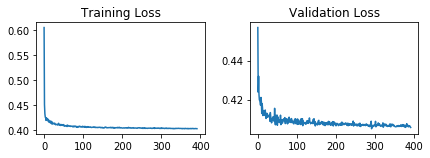

Training loss 0.40231930152062445
Validation loss 0.40497107271637234


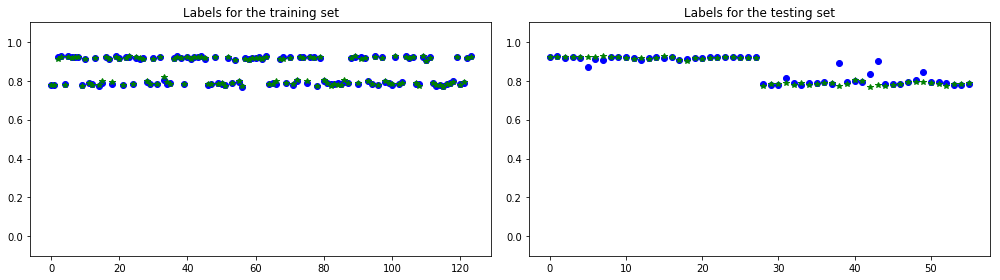

mean absolute deviation 0.013002163005345579
rms deviation 0.027489495656833528


In [9]:
Mean_abs_dev, RMS_dev  = Network()